In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import final_project.config as c
import final_project.logic.Utils as u
from final_project.logic.Utils import Axis, EulerAngle as EA
from final_project.models.Trajectory import Trajectory

# "#1b7837", "#de77ae", "#762a83"
COLORS = ["gold", "cyan", "lightgreen", 'k']

In [2]:
# load data:
rel_pnp_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_cameras.pkl"))
abs_pnp_cameras = pd.Series(u.convert_to_absolute_cameras(rel_pnp_cameras), index=rel_pnp_cameras.index, name=rel_pnp_cameras.name)
pnp_traj = Trajectory.from_absolute_cameras(abs_pnp_cameras)

rel_ba_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "ba_cameras.pkl"))
abs_ba_cameras = pd.Series(u.convert_to_absolute_cameras(rel_ba_cameras), index=rel_ba_cameras.index, name=rel_ba_cameras.name)
ba_traj = Trajectory.from_absolute_cameras(abs_ba_cameras)

rel_pg_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pg_cameras.pkl"))
abs_pg_cameras = pd.Series(u.convert_to_absolute_cameras(rel_pg_cameras), index=rel_pg_cameras.index, name=rel_pg_cameras.name)
pg_traj = Trajectory.from_absolute_cameras(abs_pg_cameras)

rel_gt_cameras = pd.Series(u.read_ground_truth_cameras(use_relative=True), index=rel_pnp_cameras.index, name="gt_cameras")
abs_gt_cameras = pd.Series(u.read_ground_truth_cameras(use_relative=False), index=rel_gt_cameras.index, name=rel_gt_cameras.name)
gt_traj = Trajectory.from_absolute_cameras(abs_gt_cameras)

In [14]:
def calculate_absolute_distances(est_cams, gt_cams, axis: Axis) -> pd.Series:
    assert len(est_cams) == len(gt_cams)
    est = Trajectory.from_absolute_cameras(est_cams)
    gt = Trajectory.from_absolute_cameras(gt_cams)
    if axis == Axis.ALL:
        diff = est.calculate_distance(gt)
    else:
        diff = est._get_axis(axis) - gt._get_axis(axis)
    res = pd.Series(diff, name=axis.name, index=est_cams.index)
    # return res  # uncomment if we want distances in real values, not absolute values
    return abs(res)


def calculate_absolute_angle_differences(est_cams, gt_cams, a: EA):
    num_cams = len(est_cams)
    assert num_cams == len(gt_cams)
    angles = np.zeros((num_cams, 3))
    for i, idx in enumerate(est_cams.index):
        ecam = est_cams[idx]
        gtcam = gt_cams[idx]
        angles[i] = ecam.angles_between(gtcam)
    data = angles.T[a.value]  # take only a single ang yaw/pitch/roll
    res = pd.Series(data, index=est_cams.index, name=a.name)
    # return res  # uncomment if we want angles in real values, not absolute values
    return abs(res)

##### Figure 10
left: Distance (on each axis) between Estimation & G.T.
right: Degree Difference (Euler angles) between Estimation and G.T.

<Figure size 432x288 with 0 Axes>

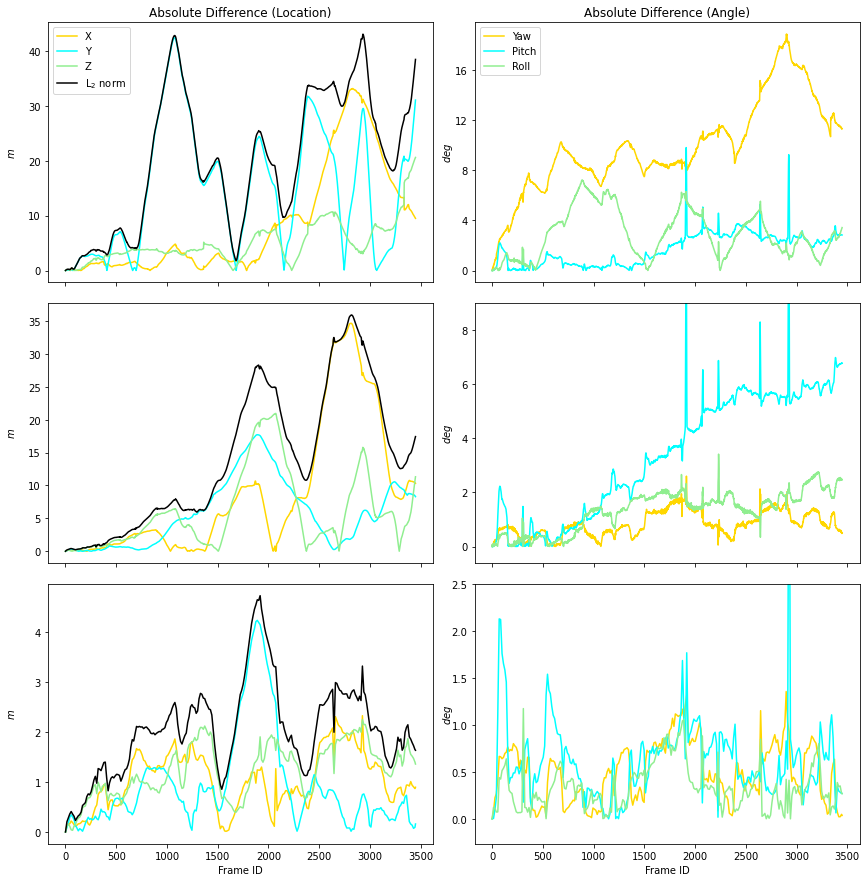

In [32]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharex='col')
fig.tight_layout()

abs_cameras = [abs_pnp_cameras, abs_ba_cameras, abs_pg_cameras]
for i in range(3):
    left_ax, right_ax = axes[i, 0], axes[i, 1]
    estimation_cameras = abs_cameras[i]
    ground_truth_cameras = abs_gt_cameras[abs_gt_cameras.index.isin(estimation_cameras.index)] if i == 2 else abs_gt_cameras
    for a in Axis:
        data = calculate_absolute_distances(estimation_cameras, ground_truth_cameras, a)
        label = "L$_2$ norm" if a == Axis.ALL else a.name
        left_ax.plot(estimation_cameras.index, data, c=COLORS[a.value], label=label.capitalize())
        left_ax.set_ylabel("$m$")
        left_ax.yaxis.set_label_coords(-0.08, 0.5)
    for a in EA:
        data = calculate_absolute_angle_differences(estimation_cameras, ground_truth_cameras, a)
        right_ax.plot(estimation_cameras.index, data, c=COLORS[a.value], label=a.name.capitalize())
        right_ax.set_ylabel("$deg$")
        right_ax.yaxis.set_label_coords(-0.05, 0.5)



# add graphics
axes[0, 0].set_title("Absolute Difference (Location)")
axes[0, 0].legend()
axes[2, 0].set_xlabel("Frame ID")

axes[0, 1].set_title("Absolute Difference (Angle)")
axes[0, 1].legend()
axes[2, 1].set_xlabel("Frame ID")

# visualization corrections
axes[0, 1].set_yticks(np.arange(0, 20, 4))
axes[1, 1].set_ylim(bottom=axes[1, 1].get_ylim()[0], top=9)
axes[2, 1].set_ylim(bottom=axes[2, 1].get_ylim()[0], top=2.5)

plt.show()

In [6]:
# Compare two methods of calculating Euler Angles
# 1- Using scipy's built-in function
# 2- Using function from https://learnopencv.com/rotation-matrix-to-euler-angles/
# Result -- same up to sign (+x / -x) which is ok because we're only interested in absolute values


import math
from scipy.spatial.transform import Rotation as rot

def calc_angles(cam):
    scipy_rot = rot.from_matrix(cam.R)
    yaw, pitch, roll = scipy_rot.as_euler('zyx', degrees=False)
    return yaw, pitch, roll


def calculate_euler_difference(cams1, cams2, e: EA):
    angles1 = cams1.apply(lambda cam: calc_angles(cam)[e.value])
    angles2 = cams2.apply(lambda cam: calc_angles(cam)[e.value])
    s = angles1 - angles2
    # s[s > 180] -= 360
    # s[s < -180] += 360
    s.name = e.name
    s.index = cams1.index
    return s


yaw = calculate_euler_difference(abs_pnp_cameras, abs_gt_cameras, EA.YAW)
pitch = calculate_euler_difference(abs_pnp_cameras, abs_gt_cameras, EA.PITCH)
roll = calculate_euler_difference(abs_pnp_cameras, abs_gt_cameras, EA.ROLL)

y555, p555, r555 = math.degrees(yaw[555]), math.degrees(pitch[555]), math.degrees(roll[555])

c1 = abs_pnp_cameras[555]
gt_c1 = abs_gt_cameras[555]
y555_2, p555_2, r555_2 = c1.angles_between(gt_c1)

print(f"{y555:.3f}\t{y555_2:.3f}")
print(f"{p555:.3f}\t{p555_2:.3f}")
print(f"{r555:.3f}\t{r555_2:.3f}")

7.255	-7.283
-1.243	1.239
-3.162	3.163
